In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation with additional transformations
img_gen = ImageDataGenerator(
    rescale=1.0/255,
    zoom_range=0.1,
    horizontal_flip=True,
)

# Test Data Augmentation (no additional transformations)
test_gen = ImageDataGenerator(rescale=1.0/255)

# Data loading with updated augmentation and binary class mode
train_dataset = img_gen.flow_from_directory(
    '/content/drive/MyDrive/data/rvf10k/train',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',  # Changed to binary for real/fake classification
    batch_size=32,
)

val_dataset = img_gen.flow_from_directory(
    '/content/drive/MyDrive/data/rvf10k/valid',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',  # Changed to binary
    batch_size=32,
)

test_dataset = test_gen.flow_from_directory(
    '/content/drive/MyDrive/data/rvf10k/test',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',  # Changed to binary
    batch_size=32,
)

Found 7000 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Build the CNN model with binary output
def build_cnn_model(input_shape=(224, 224, 3), num_classes=1):  # Adjusted for binary classification
    # Load MobileNetV2 with ImageNet weights, excluding the top layers
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze all layers in the base model to avoid re-training them
    for layer in base_model.layers:
        layer.trainable = False

    # Create a new model with additional custom layers
    model = Sequential([
        base_model,
        tfl.GlobalAveragePooling2D(),  # Converts feature maps to a single vector
        tfl.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # L2 regularization
        tfl.BatchNormalization(),  # Normalize activations for stable training
        tfl.Dropout(0.5),  # Dropout for regularization
        tfl.Dense(num_classes, activation='softmax')  # Output layer with sigmoid for binary classification
    ])

    return model

In [ ]:
def build_cnn_model():
    base_model=MobileNetV2(weights='imagenet',include_top=False,input_shape=(224,224,3))
    for layer in base_model.layers:
        layer.trainable=False
    model=Sequential([
        base_model,
        tfl.GlobalAveragePooling2D(),
        tfl.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # L2 regularization
        tfl.BatchNormalization(),
        tfl.Dropout(0.5),
        tfl.Dense(2,activation='softmax')
    ])

    return model

In [ ]:
# Build the CNN model
def build_cnn_model(input_shape=(224, 224, 3), num_classes=2):
    # Load MobileNetV2 with ImageNet weights, excluding the top layers
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze some layers in the base model
    for layer in base_model.layers[:100]:
        layer.trainable = False

    # Create a new model with additional custom layers
    model = Sequential([
        base_model,
        tfl.GlobalAveragePooling2D(), # Converts feature maps to a single vector
        tfl.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)), # Dense layer with L2 regularization
        tfl.BatchNormalization(),
        tfl.Dropout(0.5), # Increased dropout rate
        tfl.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)), # Additional dense layer with L2 regularization
        tfl.BatchNormalization(),
        tfl.Dropout(0.5), # Increased dropout rate
        tfl.Dense(num_classes, activation='softmax') # Output layer with softmax for classification
    ])

    return model

In [ ]:
# Instantiate the model
classifier_model = build_cnn_model()

In [ ]:
# Compile the model with an Adam optimizer and categorical cross-entropy loss
optimizer = Adam(learning_rate=0.001)  # Set a learning rate for Adam
classifier_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']  # You can add more metrics if needed
)

In [ ]:
# Define callbacks for early stopping and model checkpointing
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),  # Stop early if no improvement
    ModelCheckpoint('Model1.keras',
                    monitor='val_accuracy',  # Monitor validation accuracy
                    mode='max',  # Save when validation accuracy is highest
                    save_best_only=True,  # Save only the best model
                    verbose=1)  # Save the best model
]

In [ ]:
# Fit the model with training and validation datasets
history = classifier_model.fit(
    train_dataset,  # Your training dataset
    validation_data=val_dataset,  # Your validation dataset
    epochs=5,  # Adjust the number of epochs as needed
    callbacks=callbacks  # Add callbacks for early stopping and checkpointing
)

Epoch 1/5
219/219 [==============================] - ETA: 0s - loss: 1.7291 - accuracy: 0.7196
Epoch 1: val_accuracy improved from -inf to 0.46333, saving model to Model1.keras
219/219 [==============================] - 2065s 9s/step - loss: 1.7291 - accuracy: 0.7196 - val_loss: 13.8807 - val_accuracy: 0.4633
Epoch 2/5
219/219 [==============================] - ETA: 0s - loss: 1.2296 - accuracy: 0.8409
Epoch 2: val_accuracy did not improve from 0.46333
219/219 [==============================] - 140s 640ms/step - loss: 1.2296 - accuracy: 0.8409 - val_loss: 13.7835 - val_accuracy: 0.4633
Epoch 3/5
219/219 [==============================] - ETA: 0s - loss: 0.9290 - accuracy: 0.8973
Epoch 3: val_accuracy did not improve from 0.46333
219/219 [==============================] - 138s 633ms/step - loss: 0.9290 - accuracy: 0.8973 - val_loss: 11.7833 - val_accuracy: 0.4633
Epoch 4/5
219/219 [==============================] - ETA: 0s - loss: 0.7276 - accuracy: 0.9121
Epoch 4: val_accuracy improved

In [ ]:
classifier_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

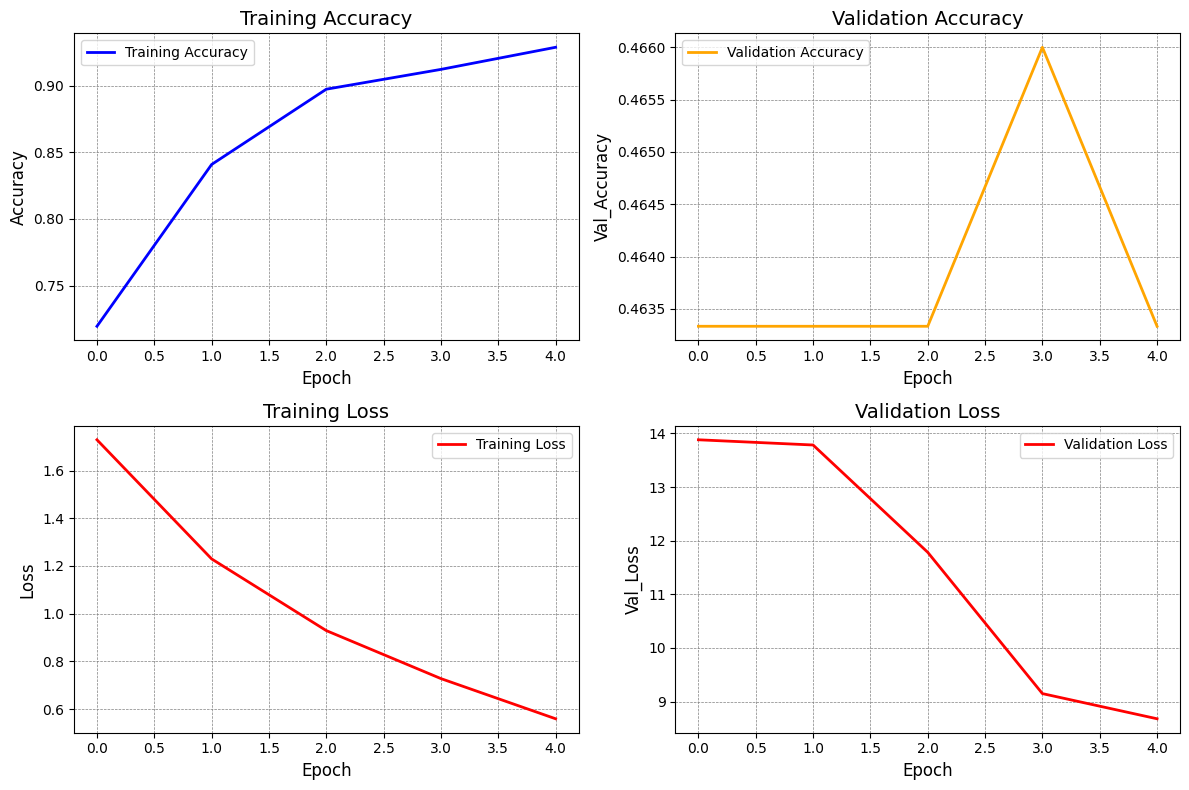

In [ ]:
# Create a 2x2 subplot for accuracy and loss (training and validation)
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plotting the training and validation accuracy
axs[0, 0].plot(history.history["accuracy"], label="Training Accuracy", color='b', linestyle='-', linewidth=2)

# Adding a title, labels, and legend to the accuracy plot
axs[0, 0].set_title("Training Accuracy", fontsize=14)
axs[0, 0].set_xlabel("Epoch", fontsize=12)
axs[0, 0].set_ylabel("Accuracy", fontsize=12)
axs[0, 0].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
axs[0, 0].legend(loc='best', fontsize=10)

# Plotting the training and validation loss
axs[1, 0].plot(history.history["loss"], label="Training Loss", color='r', linestyle='-', linewidth=2)

# Adding a title, labels, and legend to the loss plot
axs[1, 0].set_title("Training Loss", fontsize=14)
axs[1, 0].set_xlabel("Epoch", fontsize=12)
axs[1, 0].set_ylabel("Loss", fontsize=12)
axs[1, 0].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
axs[1, 0].legend(loc='best', fontsize=10)


# Plotting the training and validation loss
axs[1, 1].plot(history.history["val_loss"], label="Validation Loss", color='r', linestyle='-', linewidth=2)

# Adding a title, labels, and legend to the loss plot
axs[1, 1].set_title("Validation Loss", fontsize=14)
axs[1, 1].set_xlabel("Epoch", fontsize=12)
axs[1, 1].set_ylabel("Val_Loss", fontsize=12)
axs[1, 1].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
axs[1, 1].legend(loc='best', fontsize=10)


# Plotting the training and validation loss
axs[0, 1].plot(history.history["val_accuracy"], label="Validation Accuracy", color='orange', linestyle='-', linewidth=2)

# Adding a title, labels, and legend to the loss plot
axs[0, 1].set_title("Validation Accuracy", fontsize=14)
axs[0, 1].set_xlabel("Epoch", fontsize=12)
axs[0, 1].set_ylabel("Val_Accuracy", fontsize=12)
axs[0, 1].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
axs[0, 1].legend(loc='best', fontsize=10)

# General settings for the figure
plt.tight_layout()  # Adjust subplot spacing for better fit

# Display the plot
plt.show()

In [ ]:
images=[]
labels=[]
classes=['fake','real']
for imgbatch in test_dataset:
    images=imgbatch[0]
    labels=imgbatch[1]
    break
print("images : ",len(images),images.shape)
print("labels : ",len(labels),labels.shape)

images :  32 (32, 224, 224, 3)
labels :  32 (32, 2)


In [ ]:
predictions = classifier_model.predict(images,verbose=2)

1/1 - 1s - 1s/epoch - 1s/step


In [ ]:
# Convert predicted probabilities to class labels (choose the class with the highest probability)
predicted_labels = np.argmax(predictions, axis=1)

# Convert true labels from one-hot encoding to class labels
true_labels = np.argmax(labels, axis=1)

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=classes)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

        fake       0.47      1.00      0.64        15
        real       0.00      0.00      0.00        17

    accuracy                           0.47        32
   macro avg       0.23      0.50      0.32        32
weighted avg       0.22      0.47      0.30        32



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


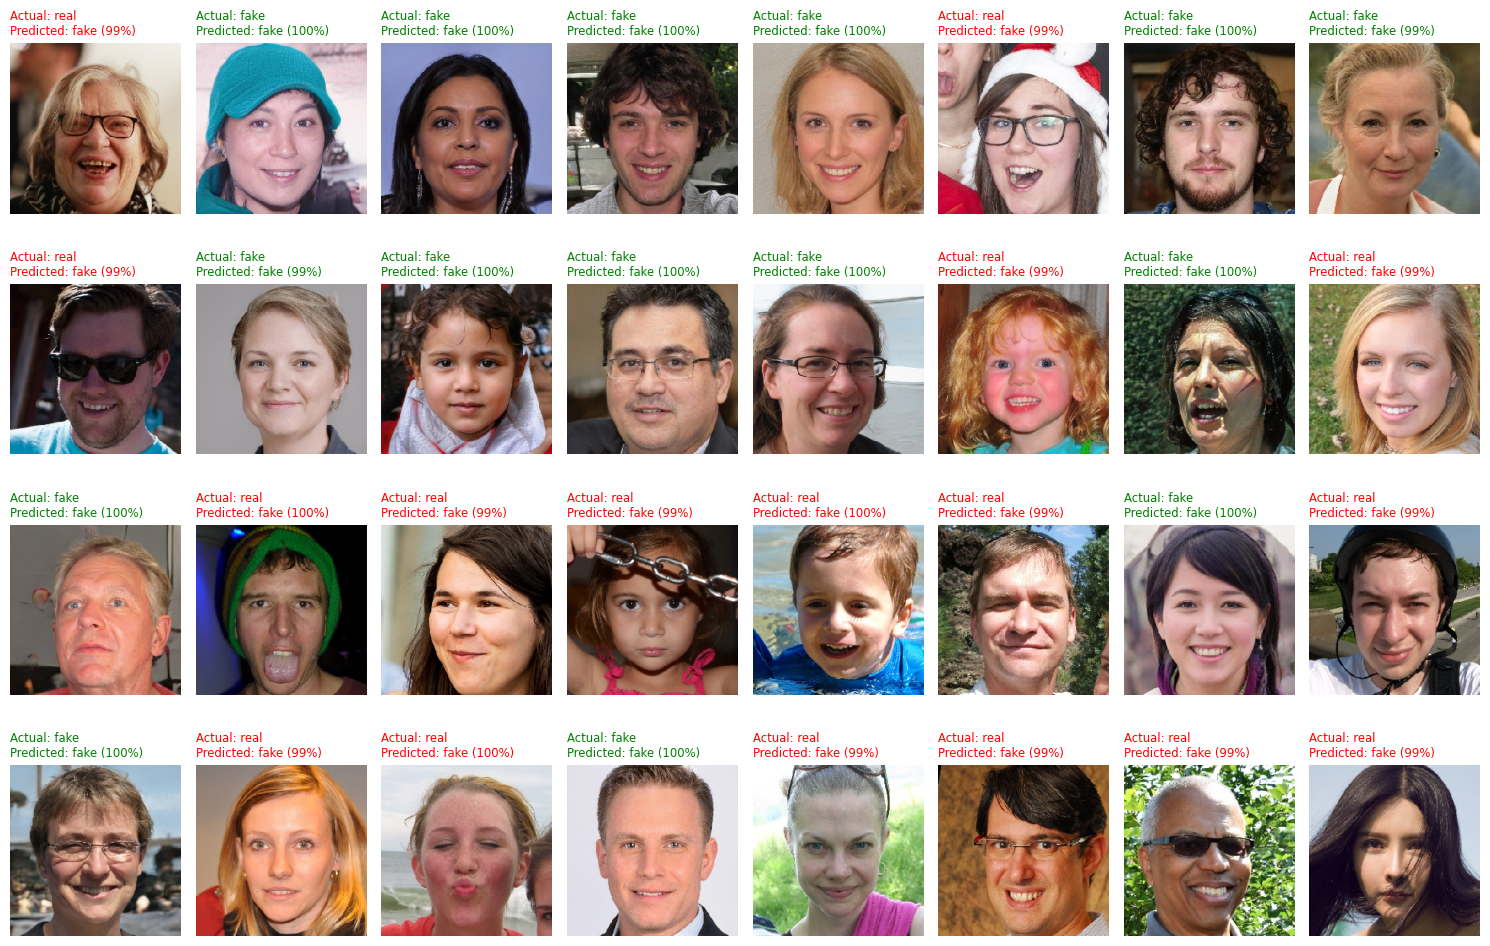

In [ ]:
# Create a 4x8 grid of subplots
rows, cols = 4, 8
fig, axs = plt.subplots(rows, cols, figsize=(15, 10))

# Loop through the images and plot them with their corresponding true labels
for nn in range(min(len(images), rows * cols)):  # Ensure we don't exceed grid size
    row = nn // cols  # Get the row index
    col = nn % cols   # Get the column index

    ax = axs[row, col]

    # Display the image
    ax.imshow(images[nn], cmap='viridis')  # Change color map as needed

    # Determine the true label from one-hot encoding
    trueLabel = classes[np.argmax(labels[nn])]

    # Get the predicted label and confidence
    predictionLabel = classes[np.argmax(predictions[nn])]
    predictConf = int(1000 * max(predictions[nn]) / 10)

    # Determine the color based on whether the prediction is correct
    if trueLabel == predictionLabel:
        color = 'green'  # Correct prediction
    else:
        color = 'red'  # Incorrect prediction

    # Set subplot title with true label, prediction, and text color
    labelString = f"Actual: {trueLabel}\nPredicted: {predictionLabel} ({predictConf}%)"
    ax.set_title(labelString, fontsize='small', loc='left', color=color)
    ax.axis('off')

# Handle unused subplots if images are fewer than grid slots
for nn in range(len(images), rows * cols):
    row = nn // cols
    col = nn % cols
    fig.delaxes(axs[row, col])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()